# HAIPW simulation

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import math
import datetime
import pathlib
import os
from tqdm import tqdm

# Import from our modules
from dgp import (
    generate_graph, 
    generate_covariates, 
    generate_potential_outcomes,
    assign_treatment, 
    compute_exposure, 
    observed_outcome
)
from propensity import (
    monte_carlo_probabilities, 
    build_lambdas, 
    build_kn_matrix
)
from estimators import compute_all_estimators_once

%matplotlib inline

estimators we construct:

1. HT estimator 

2. Hajek estimator

3. haipw estimator (first strategy): 3 of them, combinations of
    (matrix, vector) = (truth, one-sided), (one-sided, one-sided), (regression, regression)

4. haipw-cov estimator (first strategy): 3 of them, combinations of
    (matrix, vector) = (truth, one-sided), (one-sided, one-sided), (regression, regression)


In [2]:
# ---------- One-shot runner that fixes (G, X, Y_pot), then repeats assignments ----------
def run_simulation_all_in_one(
    # --- data gen / design ---
    n=200, avg_degree=3.0, max_degree=9, k=3,
    treated_fraction=1/3,
    # exposures to compare
    d1=0, d2=2,
    # MC for pi’s
    mc_reps=1000, seed_mc=111,
    # seeds
    seed_graph=123, seed_cov=1234, seed_out=999,
    # experiment reps
    B=200,
    # options
    eps=1e-12,
):
    """
    Full pipeline: generate (G,X,Y_pot), compute probabilities and Lambda's, then run
    HT, Hájek, and 3×HAIPW + 3×HAIPW-cov (matrix, vector) ∈ {(truth, one_sided), (one_sided, one_sided), (regression, regression)} for B randomizations.

    Returns:
      {
        'G','H','X','Y_pot','pi_id_all','L1','L2','L12','true_tau',
        'results': {estimator_key -> np.ndarray of length B},
        'summary': {estimator_key -> {'bias':..., 'sd':...}}
      }
    """
    # -------------------------
    # Steps 1–3: graph & covariates & potential outcomes
    # -------------------------
    G, H = generate_graph(n=n, avg_degree=avg_degree, max_degree=max_degree, seed=seed_graph)
    X, X_noi = generate_covariates(H, seed=seed_cov)
    Y_pot = generate_potential_outcomes(H, X_noi, k=k, seed=seed_out)
    true_tau = float(np.mean(Y_pot[:, d1] - Y_pot[:, d2]))

    # -------------------------
    # Step 7: MC probs π_i(d) and π_ij(...)
    # -------------------------
    pi_id_all, pi_ij_d1d2, pi_ij_d1d1, pi_ij_d2d2 = monte_carlo_probabilities(
        G, treated_fraction, k, mc_reps, seed_mc, d1, d2
    )

    # -------------------------
    # Step 8: Λ and Kn matrices
    # -------------------------
    L1, L2, L12 = build_lambdas(pi_id_all, pi_ij_d1d2, pi_ij_d1d1, pi_ij_d2d2, d1, d2)
    # Generate Kn: indicator matrix where (i,j) = 1 if nodes i and j have common neighbors
    Kn = (G @ G.T > 0).astype(int)

    # -------------------------
    # Pre-compute estimator keys by one dry run
    # -------------------------
    treated_count = int(round(treated_fraction * n))
    A0 = assign_treatment(n, treated_fraction=treated_fraction, seed=None)
    D0 = compute_exposure(G, A0, k)
    Y0 = observed_outcome(Y_pot, D0, k=k)
    probe_out, probe_beta = compute_all_estimators_once(Y0, D0, X, d1, d2, L1, L2, L12, Kn, pi_id_all, eps)
    keys = list(probe_out.keys())

    # storage
    results = {k: np.zeros(B, dtype=float) for k in keys}
    # Only create beta_out storage for keys that actually have beta values (from probe)
    # Beta values are arrays, so we use a list to store them across replicates
    beta_out = {k: [] for k in probe_beta.keys()}

    # -------------------------
    # Repeat randomizations B times
    # -------------------------
    for b in tqdm(range(B), desc="Monte Carlo simulations"):
        A = assign_treatment(n, treated_fraction=treated_fraction, seed=None)
        D = compute_exposure(G, A, k)
        Y = observed_outcome(Y_pot, D, k=k)

        res = compute_all_estimators_once(Y, D, X, d1, d2, L1, L2, L12, Kn, pi_id_all, eps)
        for key in keys:
            results[key][b] = res[0][key]
            if key in res[1]:  # Only store beta if it exists
                beta_out[key].append(res[1][key])

    # Convert beta_out lists to numpy arrays for easier analysis
    for key in beta_out.keys():
        beta_out[key] = np.array(beta_out[key])

    # -------------------------
    # Summaries (bias vs true_tau, and sd)
    # -------------------------
    summary = {k: {"bias": float(np.mean(v) - true_tau), "sd": float(np.std(v, ddof=1)), 
                   "rmse": float(np.sqrt((np.mean(v) - true_tau) ** 2 + np.std(v, ddof=1) ** 2))}
               for k, v in results.items()}

    out = dict(
        G=G, H=H, X=X, Y_pot=Y_pot,
        pi_id_all=pi_id_all, L1=L1, L2=L2, L12=L12, Kn=Kn,
        true_tau=true_tau,
        results=results,
        summary=summary,
        beta_out=beta_out
    )
    return out

In [3]:
# run simulations for 4 different setup
# B is the number of MC, mc_reps is used to compute the pscores
out1 = run_simulation_all_in_one(
    n=2000, avg_degree=3.0, max_degree=9, k=3,
    treated_fraction=1/3,
    d1=0, d2=2,
    mc_reps=500, seed_mc=111,
    seed_graph=123, seed_cov=1234, seed_out=999,
    B=1000,
    eps=1e-12
)

Monte Carlo simulations: 100%|██████████| 1000/1000 [00:24<00:00, 40.47it/s]


In [4]:
out1["summary"]

{'tau_ht': {'bias': -0.12005387770163001,
  'sd': 0.43834042585270855,
  'rmse': 0.45448351178885665},
 'tau_hajek': {'bias': -0.019206496377021542,
  'sd': 0.17770637782928966,
  'rmse': 0.17874128293230637},
 'tau_haipw[M=truth,V=one_sided]': {'bias': 0.09937669524458415,
  'sd': 0.27327283156541426,
  'rmse': 0.29078130618991693},
 'tau_haipw[M=one_sided,V=one_sided]': {'bias': 0.008006812555589438,
  'sd': 0.1539221046818278,
  'rmse': 0.15413021558728807},
 'tau_haipw[M=regression,V=regression]': {'bias': 0.011358282800546182,
  'sd': 0.15515429580932327,
  'rmse': 0.15556948960597697},
 'tau_haipw_cov[M=truth,V=one_sided]': {'bias': 0.32971072830517956,
  'sd': 0.471163969983259,
  'rmse': 0.5750692575420089},
 'tau_haipw_cov[M=one_sided,V=one_sided]': {'bias': 0.014293603855872306,
  'sd': 0.11574126439005468,
  'rmse': 0.11662052732601215},
 'tau_haipw_cov[M=regression,V=regression]': {'bias': 0.03667447398586565,
  'sd': 0.1102445662138677,
  'rmse': 0.11618468669245442}}

In [14]:
out2 = run_simulation_all_in_one(
    n=2000, avg_degree=5, max_degree=9, k=3,
    treated_fraction=1/2,
    d1=0, d2=2,
    mc_reps=5000, seed_mc=111,
    seed_graph=2025, seed_cov=121212, seed_out=161616,
    B=1000,
    eps=1e-12
)

NameError: name 'build_lambdas' is not defined

In [ ]:
out2["summary"]

{'tau_ht': {'bias': 0.009241619996592565,
  'sd': 0.39770183886258215,
  'rmse': 0.3978092007166761},
 'tau_hajek': {'bias': 0.0041842724648040175,
  'sd': 0.1645527770901509,
  'rmse': 0.1646059676443737},
 'tau_haipw[M=truth,V=one_sided]': {'bias': -0.002026712592183899,
  'sd': 0.15519613229517337,
  'rmse': 0.15520936519202788},
 'tau_haipw[M=one_sided,V=one_sided]': {'bias': 0.0033968756492774865,
  'sd': 0.15062980857266878,
  'rmse': 0.1506681054331523},
 'tau_haipw[M=regression,V=regression]': {'bias': 0.015101759601175546,
  'sd': 0.15243043206617704,
  'rmse': 0.15317669458156197},
 'tau_haipw_cov[M=truth,V=one_sided]': {'bias': -0.031567109688552364,
  'sd': 0.11561048703899023,
  'rmse': 0.11984267657008343},
 'tau_haipw_cov[M=one_sided,V=one_sided]': {'bias': -0.0006524244957314407,
  'sd': 0.08238792674188154,
  'rmse': 0.08239050995441326},
 'tau_haipw_cov[M=regression,V=regression]': {'bias': 0.0728868949489796,
  'sd': 0.087716443893245,
  'rmse': 0.11404680611301829}}

In [ ]:
out3 = run_simulation_all_in_one(
    n=2000, avg_degree=10, max_degree=19, k=3,
    treated_fraction=1/2,
    d1=0, d2=2,
    mc_reps=5000, seed_mc=111,
    seed_graph=202512, seed_cov=1212, seed_out=1818,
    B=1000,
    eps=1e-12
)

Monte Carlo simulations: 100%|██████████| 1000/1000 [00:27<00:00, 35.91it/s]


In [ ]:
out3["summary"]

{'tau_ht': {'bias': 0.06599763379750223,
  'sd': 1.1411028185266991,
  'rmse': 1.1430097681631797},
 'tau_hajek': {'bias': 0.015993971464810852,
  'sd': 0.45005861305923034,
  'rmse': 0.45034271650823354},
 'tau_haipw[M=truth,V=one_sided]': {'bias': -0.005655360047022384,
  'sd': 0.43019524414343063,
  'rmse': 0.4302324153069912},
 'tau_haipw[M=one_sided,V=one_sided]': {'bias': 0.0089294548349802,
  'sd': 0.4132796879635409,
  'rmse': 0.4133761430548354},
 'tau_haipw[M=regression,V=regression]': {'bias': 0.05748646308225369,
  'sd': 0.4134124563335727,
  'rmse': 0.41739016817537217},
 'tau_haipw_cov[M=truth,V=one_sided]': {'bias': -0.11408975955278766,
  'sd': 0.35148201944924207,
  'rmse': 0.36953495535731157},
 'tau_haipw_cov[M=one_sided,V=one_sided]': {'bias': 0.002240849949432855,
  'sd': 0.13844209271503227,
  'rmse': 0.13846022693832863},
 'tau_haipw_cov[M=regression,V=regression]': {'bias': 0.05570374336094164,
  'sd': 0.15722956370351052,
  'rmse': 0.16680540376983571}}

In [ ]:
out4 = run_simulation_all_in_one(
    n=2000, avg_degree=10, max_degree=19, k=2,
    treated_fraction=1/2,
    d1=0, d2=1,
    mc_reps=5000, seed_mc=42,
    seed_graph=42, seed_cov=42, seed_out=42,
    B=1000,
    eps=1e-12
)

Monte Carlo simulations: 100%|██████████| 1000/1000 [00:27<00:00, 36.48it/s]


In [ ]:
out4["summary"]

{'tau_ht': {'bias': -0.0016037526689489101,
  'sd': 0.48208029526298546,
  'rmse': 0.48208296288447117},
 'tau_hajek': {'bias': -0.002207609496537699,
  'sd': 0.18947807570069403,
  'rmse': 0.18949093569595127},
 'tau_haipw[M=truth,V=one_sided]': {'bias': -0.0031345198628758286,
  'sd': 0.18407598986739515,
  'rmse': 0.18410267586439943},
 'tau_haipw[M=one_sided,V=one_sided]': {'bias': -0.009398736168124144,
  'sd': 0.184851815267606,
  'rmse': 0.18509059903000782},
 'tau_haipw[M=regression,V=regression]': {'bias': 0.01777191382391985,
  'sd': 0.18168968217881643,
  'rmse': 0.1825567898797636},
 'tau_haipw_cov[M=truth,V=one_sided]': {'bias': -0.014252938661766579,
  'sd': 0.031935970079766486,
  'rmse': 0.034972166724865944},
 'tau_haipw_cov[M=one_sided,V=one_sided]': {'bias': -0.0010123004865170149,
  'sd': 0.02722868864017638,
  'rmse': 0.027247499652971335},
 'tau_haipw_cov[M=regression,V=regression]': {'bias': 0.05259811702266026,
  'sd': 0.049621431843277004,
  'rmse': 0.072310776

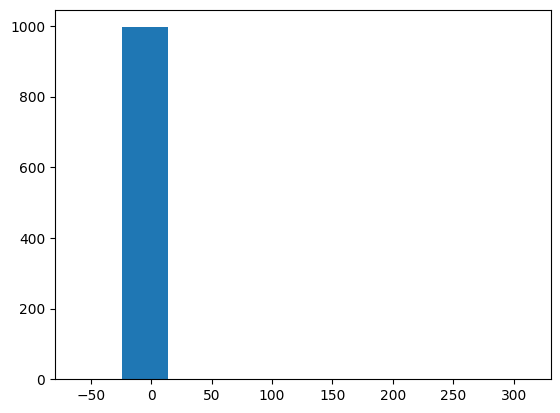

In [73]:
plt.hist(out4["beta_out"]["tau_haipw_cov[M=one_sided,V=one_sided]"][:, 1])
plt.show()

In [36]:
# ---------- helpers: tables ----------
def results_to_long_df(out):
    tt = out['true_tau']
    rows = []
    for est, arr in out['results'].items():
        for b, val in enumerate(np.asarray(arr, float)):
            rows.append((est, b, float(val), float(val - tt)))
    return pd.DataFrame(rows, columns=["estimator","replicate","tau_hat","error"])

def summary_table(out):
    tt = out['true_tau']
    rows = []
    for est, arr in out['results'].items():
        arr = np.asarray(arr, float)
        bias = float(arr.mean() - tt)
        sd   = float(arr.std(ddof=1))
        rmse = float(math.sqrt(bias**2 + sd**2))
        rows.append((est, bias, sd, rmse))
    sm = pd.DataFrame(rows, columns=["estimator","bias","sd","rmse"])
    return sm.sort_values("rmse", ascending=True).reset_index(drop=True)

def _pretty_name(key):
    if key == "tau_ht": return "HT"
    if key == "tau_hajek": return "Hájek"
    if key.startswith("tau_haipw_cov"):
        inside = key[key.find('[')+1:key.find(']')]
        return "HAIPW-cov " + inside.replace("M=","M=").replace("V="," V=")
    if key.startswith("tau_haipw"):
        inside = key[key.find('[')+1:key.find(']')]
        return "HAIPW " + inside.replace("M=","M=").replace("V="," V=")
    return key

def _split_mv(key):
    if '[' not in key: return None, None
    inside = key[key.find('[')+1:key.find(']')]
    parts = dict(s.split('=') for s in inside.split(','))
    return parts.get('M'), parts.get('V')

def _estimator_order_keys():
    Ms = ['truth','one_sided','two_sided']
    Vs = ['one_sided','two_sided']
    order = ['tau_ht', 'tau_hajek']
    for M in Ms:
        for V in Vs:
            order.append(f"tau_haipw[M={M},V={V}]")
    for M in Ms:
        for V in Vs:
            order.append(f"tau_haipw_cov[M={M},V={V}]")
    return order

# ---------- plot savers ----------
def save_errors_boxplot(out, path_png, figsize=(14,7)):
    df = results_to_long_df(out)
    order = [k for k in _estimator_order_keys() if k in out['results']]
    data = [df.loc[df['estimator']==k, 'error'].values for k in order]
    labels = [_pretty_name(k) for k in order]
    plt.figure(figsize=figsize)
    bp = plt.boxplot(data, vert=True, patch_artist=True, showfliers=False)
    for box in bp['boxes']:
        box.set_facecolor('#dddddd'); box.set_edgecolor('#444444')
    for median in bp['medians']:
        median.set_color('#222222'); median.set_linewidth(1.5)
    plt.axhline(0.0, color='k', linestyle='--', linewidth=1, alpha=0.6)
    plt.xticks(range(1, len(labels)+1), labels, rotation=45, ha='right')
    plt.ylabel(r'Error $\;\hat{\tau}-\tau^\star$'); plt.title('Estimator Errors (fixed order)')
    plt.tight_layout(); plt.savefig(path_png, dpi=200, bbox_inches='tight'); plt.close()

def save_bias_sd_rmse(out, path_png, figsize=(14,7)):
    tt = out['true_tau']
    order = [k for k in _estimator_order_keys() if k in out['results']]
    rows = []
    for k in order:
        arr = np.asarray(out['results'][k], float)
        bias = float(arr.mean() - tt)
        sd   = float(arr.std(ddof=1))
        rmse = float(math.sqrt(bias**2 + sd**2))
        rows.append((k, bias, sd, rmse))
    sm = pd.DataFrame(rows, columns=["estimator","bias","sd","rmse"])
    labels = [_pretty_name(k) for k in sm['estimator']]
    x = np.arange(len(labels)); width = 0.28
    plt.figure(figsize=figsize)
    plt.bar(x - width, sm['bias'],  width=width, label='Bias')
    plt.bar(x,          sm['sd'],    width=width, label='SD')
    plt.bar(x + width,  sm['rmse'],  width=width, label='RMSE')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Value'); plt.title('Bias / SD / RMSE (fixed order)')
    plt.legend(loc='best'); plt.tight_layout()
    plt.savefig(path_png, dpi=200, bbox_inches='tight'); plt.close()

def save_heatmaps_mv(out, path_png, figsize=(12,4)):
    sm = summary_table(out)
    sm_hp  = sm[sm['estimator'].str.startswith('tau_haipw[')].copy()
    sm_hpc = sm[sm['estimator'].str.startswith('tau_haipw_cov[')].copy()
    def to_matrix(df):
        Ms = ['truth','one_sided','two_sided']; Vs = ['one_sided','two_sided']
        grid = np.full((len(Ms), len(Vs)), np.nan)
        for _, r in df.iterrows():
            M, V = _split_mv(r['estimator'])
            if M in Ms and V in Vs:
                i, j = Ms.index(M), Vs.index(V); grid[i, j] = r['rmse']
        return grid, Ms, Vs
    grid_hp, Ms_hp, Vs_hp   = to_matrix(sm_hp)
    grid_hpc, Ms_hpc, Vs_hpc= to_matrix(sm_hpc)
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    im0 = axes[0].imshow(grid_hp, aspect='auto'); axes[0].set_title('HAIPW: RMSE')
    axes[0].set_yticks(range(len(Ms_hp))); axes[0].set_yticklabels(Ms_hp)
    axes[0].set_xticks(range(len(Vs_hp))); axes[0].set_xticklabels(Vs_hp)
    for i in range(grid_hp.shape[0]):
        for j in range(grid_hp.shape[1]):
            v = grid_hp[i,j]
            if not np.isnan(v): axes[0].text(j, i, f"{v:.3f}", ha='center', va='center', color='w')
    im1 = axes[1].imshow(grid_hpc, aspect='auto'); axes[1].set_title('HAIPW-cov: RMSE')
    axes[1].set_yticks(range(len(Ms_hpc))); axes[1].set_yticklabels(Ms_hpc)
    axes[1].set_xticks(range(len(Vs_hpc))); axes[1].set_xticklabels(Vs_hpc)
    for i in range(grid_hpc.shape[0]):
        for j in range(grid_hpc.shape[1]):
            v = grid_hpc[i,j]
            if not np.isnan(v): axes[1].text(j, i, f"{v:.3f}", ha='center', va='center', color='w')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.savefig(path_png, dpi=200, bbox_inches='tight'); plt.close()

def save_core_four(out, path_box_png, path_bar_png, figsize=(12,5)):
    wanted = ["tau_ht","tau_hajek","tau_haipw[M=two_sided,V=two_sided]","tau_haipw_cov[M=two_sided,V=two_sided]"]
    labels = ["HT","Hájek","HAIPW 2×2","HAIPW-cov 2×2"]
    keys = [k for k in wanted if k in out["results"]]
    labl = [labels[wanted.index(k)] for k in keys]
    tt = out["true_tau"]
    # boxplot
    data_errors = [out["results"][k] - tt for k in keys]
    plt.figure(figsize=figsize)
    bp = plt.boxplot(data_errors, vert=True, patch_artist=True, showfliers=False)
    for box in bp['boxes']:
        box.set_facecolor('#dddddd'); box.set_edgecolor('#444444')
    for median in bp['medians']:
        median.set_color('#222222'); median.set_linewidth(1.5)
    plt.axhline(0.0, color='k', linestyle='--', linewidth=1, alpha=0.6)
    plt.xticks(range(1, len(labl)+1), labl, rotation=15, ha='right')
    plt.ylabel(r'Error $\;\hat{\tau}-\tau^\star$'); plt.title('Errors (core four)')
    plt.tight_layout(); plt.savefig(path_box_png, dpi=200, bbox_inches='tight'); plt.close()
    # bars
    rows = []
    for k in keys:
        arr = np.asarray(out["results"][k], float)
        bias = float(arr.mean() - tt); sd = float(arr.std(ddof=1))
        rmse = float(math.sqrt(bias**2 + sd**2))
        rows.append((k, bias, sd, rmse))
    sm = pd.DataFrame(rows, columns=["estimator","bias","sd","rmse"])
    x = np.arange(len(keys)); width=0.28
    plt.figure(figsize=figsize)
    plt.bar(x - width, sm['bias'],  width=width, label='Bias')
    plt.bar(x,          sm['sd'],    width=width, label='SD')
    plt.bar(x + width,  sm['rmse'],  width=width, label='RMSE')
    plt.xticks(x, labl, rotation=15, ha='right')
    plt.ylabel('Value'); plt.title('Bias / SD / RMSE (core four)')
    plt.legend(loc='best'); plt.tight_layout()
    plt.savefig(path_bar_png, dpi=200, bbox_inches='tight'); plt.close()

In [37]:
# ============================================================================
# SUMMARY OF ALL SIMULATIONS (out1, out2, out3, out4)
# ============================================================================

def display_summary(out, name):
    """Display summary statistics for one simulation result"""
    print(f"\n{'='*80}")
    print(f"  {name}")
    print(f"{'='*80}")
    print(f"True tau: {out['true_tau']:.6f}")
    print(f"Number of replicates: {len(next(iter(out['results'].values())))}")
    print(f"\nTop 10 estimators by RMSE:")
    print("-" * 80)
    
    sm = summary_table(out)
    sm_top = sm.head(10)
    
    print(f"{'Rank':<6} {'Estimator':<45} {'Bias':>10} {'SD':>10} {'RMSE':>10}")
    print("-" * 80)
    for idx, row in sm_top.iterrows():
        print(f"{idx+1:<6} {row['estimator']:<45} {row['bias']:>10.6f} {row['sd']:>10.6f} {row['rmse']:>10.6f}")
    
    return sm

# Display all simulations
results_dict = {}

if 'out1' in locals() or 'out1' in globals():
    results_dict['out1'] = display_summary(out1, "SIMULATION 1 (out1)")

if 'out2' in locals() or 'out2' in globals():
    results_dict['out2'] = display_summary(out2, "SIMULATION 2 (out2)")

if 'out3' in locals() or 'out3' in globals():
    results_dict['out3'] = display_summary(out3, "SIMULATION 3 (out3)")

if 'out4' in locals() or 'out4' in globals():
    results_dict['out4'] = display_summary(out4, "SIMULATION 4 (out4)")

print(f"\n{'='*80}")
print(f"  COMPARISON ACROSS ALL SIMULATIONS")
print(f"{'='*80}")

# Compare best estimator across simulations
if results_dict:
    print("\nBest estimator (by RMSE) in each simulation:")
    print("-" * 80)
    print(f"{'Simulation':<15} {'Best Estimator':<45} {'RMSE':>10}")
    print("-" * 80)
    for name, sm in results_dict.items():
        best = sm.iloc[0]
        print(f"{name:<15} {best['estimator']:<45} {best['rmse']:>10.6f}")
    
    # Overall average performance of key estimators
    print(f"\n{'='*80}")
    print("Average RMSE across all simulations for key estimators:")
    print("-" * 80)
    
    key_estimators = [
        "tau_ht",
        "tau_hajek",
        "tau_haipw[M=truth,V=one_sided]",
        "tau_haipw[M=one_sided,V=one_sided]",
        "tau_haipw[M=regression,V=regression]",
        "tau_haipw_cov[M=truth,V=one_sided]",
        "tau_haipw_cov[M=one_sided,V=one_sided]",
        "tau_haipw_cov[M=regression,V=regression]"
    ]
    
    avg_rmse = {}
    for est in key_estimators:
        rmses = []
        for name, sm in results_dict.items():
            est_row = sm[sm['estimator'] == est]
            if not est_row.empty:
                rmses.append(est_row.iloc[0]['rmse'])
        if rmses:
            avg_rmse[est] = np.mean(rmses)
    
    if avg_rmse:
        sorted_avg = sorted(avg_rmse.items(), key=lambda x: x[1])
        print(f"{'Estimator':<45} {'Avg RMSE':>12} {'Count':>8}")
        print("-" * 80)
        for est, rmse in sorted_avg:
            count = sum(1 for sm in results_dict.values() if est in sm['estimator'].values)
            print(f"{est:<45} {rmse:>12.6f} {count:>8}")

print(f"\n{'='*80}")
print("SUMMARY COMPLETE")
print(f"{'='*80}")



  SIMULATION 1 (out1)
True tau: -0.593927
Number of replicates: 1000

Top 10 estimators by RMSE:
--------------------------------------------------------------------------------
Rank   Estimator                                           Bias         SD       RMSE
--------------------------------------------------------------------------------
1      tau_haipw_cov[M=regression,V=regression]        0.043478   0.100073   0.109110
2      tau_haipw_cov[M=one_sided,V=one_sided]          0.010570   0.118082   0.118555
3      tau_haipw[M=regression,V=regression]            0.017284   0.153125   0.154097
4      tau_haipw[M=one_sided,V=one_sided]              0.009870   0.155785   0.156098
5      tau_hajek                                      -0.009715   0.174355   0.174625
6      tau_haipw[M=truth,V=one_sided]                  0.090165   0.267502   0.282289
7      tau_ht                                         -0.088067   0.415708   0.424934
8      tau_haipw_cov[M=truth,V=one_sided]           

In [ ]:
with open("out1.pkl", "wb") as f:
    pickle.dump(out1, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# run simulations for 4 different setup
# out1 = run_simulation_all_in_one(
#     n=2000, avg_degree=10, max_degree=19, k=3, treated_fraction=1/3,
#     d1=0, d2=2, 
#     mc_reps=10000, seed_mc=12345,
#     seed_graph=123, seed_cov=1234, seed_out=123,
#     B=1000
# )
out2 = run_simulation_all_in_one(
    n=2000, avg_degree=5, max_degree=10, k=3, treated_fraction=2/5,
    d1=1, d2=2, 
    mc_reps=10000, seed_mc=12345,
    seed_graph=123, seed_cov=1234, seed_out=123,
    B=1000
)
out3 = run_simulation_all_in_one(
    n=2000, avg_degree=10, max_degree=19, k=3, treated_fraction=1/3,
    d1=0, d2=2, 
    mc_reps=10000, seed_mc=12345,
    seed_graph=123, seed_cov=1234, seed_out=123,
    B=1000
)
out4 = run_simulation_all_in_one(
    n=2000, avg_degree=5, max_degree=10, k=3, treated_fraction=2/5,
    d1=0, d2=2, 
    mc_reps=10000, seed_mc=12345,
    seed_graph=123, seed_cov=1234, seed_out=123,
    B=1000
)
# save the results
# with open("out1.pkl", "wb") as f:
#     pickle.dump(out1, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("out2.pkl", "wb") as f:
    pickle.dump(out2, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("out3.pkl", "wb") as f:
    pickle.dump(out3, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("out4.pkl", "wb") as f:
    pickle.dump(out4, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# ---------- config ----------
PICKLE_PATH = "out1.pkl"         # <-- change if needed
OUT_ROOT    = "outputs"         # base output directory
PREFIX      = "exp"             # optional prefix for the folder name
SAVE_CORE4  = True              # also save the 'core four' plots

# ---------- load ----------
with open(PICKLE_PATH, "rb") as f:
    out = pickle.load(f)
# coerce types
out["true_tau"] = float(out["true_tau"])
out["results"]  = {k: np.asarray(v, dtype=float) for k, v in out["results"].items()}

In [ ]:
# ---------- helpers: tables ----------
def results_to_long_df(out):
    tt = out['true_tau']
    rows = []
    for est, arr in out['results'].items():
        for b, val in enumerate(np.asarray(arr, float)):
            rows.append((est, b, float(val), float(val - tt)))
    return pd.DataFrame(rows, columns=["estimator","replicate","tau_hat","error"])

def summary_table(out):
    tt = out['true_tau']
    rows = []
    for est, arr in out['results'].items():
        arr = np.asarray(arr, float)
        bias = float(arr.mean() - tt)
        sd   = float(arr.std(ddof=1))
        rmse = float(math.sqrt(bias**2 + sd**2))
        rows.append((est, bias, sd, rmse))
    sm = pd.DataFrame(rows, columns=["estimator","bias","sd","rmse"])
    return sm.sort_values("rmse", ascending=True).reset_index(drop=True)

def _pretty_name(key):
    if key == "tau_ht": return "HT"
    if key == "tau_hajek": return "Hájek"
    if key.startswith("tau_haipw_cov"):
        inside = key[key.find('[')+1:key.find(']')]
        return "HAIPW-cov " + inside.replace("M=","M=").replace("V="," V=")
    if key.startswith("tau_haipw"):
        inside = key[key.find('[')+1:key.find(']')]
        return "HAIPW " + inside.replace("M=","M=").replace("V="," V=")
    return key

def _split_mv(key):
    if '[' not in key: return None, None
    inside = key[key.find('[')+1:key.find(']')]
    parts = dict(s.split('=') for s in inside.split(','))
    return parts.get('M'), parts.get('V')

def _estimator_order_keys():
    Ms = ['truth','one_sided','two_sided']
    Vs = ['one_sided','two_sided']
    order = ['tau_ht', 'tau_hajek']
    for M in Ms:
        for V in Vs:
            order.append(f"tau_haipw[M={M},V={V}]")
    for M in Ms:
        for V in Vs:
            order.append(f"tau_haipw_cov[M={M},V={V}]")
    return order

# ---------- plot savers ----------
def save_errors_boxplot(out, path_png, figsize=(14,7)):
    df = results_to_long_df(out)
    order = [k for k in _estimator_order_keys() if k in out['results']]
    data = [df.loc[df['estimator']==k, 'error'].values for k in order]
    labels = [_pretty_name(k) for k in order]
    plt.figure(figsize=figsize)
    bp = plt.boxplot(data, vert=True, patch_artist=True, showfliers=False)
    for box in bp['boxes']:
        box.set_facecolor('#dddddd'); box.set_edgecolor('#444444')
    for median in bp['medians']:
        median.set_color('#222222'); median.set_linewidth(1.5)
    plt.axhline(0.0, color='k', linestyle='--', linewidth=1, alpha=0.6)
    plt.xticks(range(1, len(labels)+1), labels, rotation=45, ha='right')
    plt.ylabel(r'Error $\;\hat{\tau}-\tau^\star$'); plt.title('Estimator Errors (fixed order)')
    plt.tight_layout(); plt.savefig(path_png, dpi=200, bbox_inches='tight'); plt.close()

def save_bias_sd_rmse(out, path_png, figsize=(14,7)):
    tt = out['true_tau']
    order = [k for k in _estimator_order_keys() if k in out['results']]
    rows = []
    for k in order:
        arr = np.asarray(out['results'][k], float)
        bias = float(arr.mean() - tt)
        sd   = float(arr.std(ddof=1))
        rmse = float(math.sqrt(bias**2 + sd**2))
        rows.append((k, bias, sd, rmse))
    sm = pd.DataFrame(rows, columns=["estimator","bias","sd","rmse"])
    labels = [_pretty_name(k) for k in sm['estimator']]
    x = np.arange(len(labels)); width = 0.28
    plt.figure(figsize=figsize)
    plt.bar(x - width, sm['bias'],  width=width, label='Bias')
    plt.bar(x,          sm['sd'],    width=width, label='SD')
    plt.bar(x + width,  sm['rmse'],  width=width, label='RMSE')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Value'); plt.title('Bias / SD / RMSE (fixed order)')
    plt.legend(loc='best'); plt.tight_layout()
    plt.savefig(path_png, dpi=200, bbox_inches='tight'); plt.close()

def save_heatmaps_mv(out, path_png, figsize=(12,4)):
    sm = summary_table(out)
    sm_hp  = sm[sm['estimator'].str.startswith('tau_haipw[')].copy()
    sm_hpc = sm[sm['estimator'].str.startswith('tau_haipw_cov[')].copy()
    def to_matrix(df):
        Ms = ['truth','one_sided','two_sided']; Vs = ['one_sided','two_sided']
        grid = np.full((len(Ms), len(Vs)), np.nan)
        for _, r in df.iterrows():
            M, V = _split_mv(r['estimator'])
            if M in Ms and V in Vs:
                i, j = Ms.index(M), Vs.index(V); grid[i, j] = r['rmse']
        return grid, Ms, Vs
    grid_hp, Ms_hp, Vs_hp   = to_matrix(sm_hp)
    grid_hpc, Ms_hpc, Vs_hpc= to_matrix(sm_hpc)
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    im0 = axes[0].imshow(grid_hp, aspect='auto'); axes[0].set_title('HAIPW: RMSE')
    axes[0].set_yticks(range(len(Ms_hp))); axes[0].set_yticklabels(Ms_hp)
    axes[0].set_xticks(range(len(Vs_hp))); axes[0].set_xticklabels(Vs_hp)
    for i in range(grid_hp.shape[0]):
        for j in range(grid_hp.shape[1]):
            v = grid_hp[i,j]
            if not np.isnan(v): axes[0].text(j, i, f"{v:.3f}", ha='center', va='center', color='w')
    im1 = axes[1].imshow(grid_hpc, aspect='auto'); axes[1].set_title('HAIPW-cov: RMSE')
    axes[1].set_yticks(range(len(Ms_hpc))); axes[1].set_yticklabels(Ms_hpc)
    axes[1].set_xticks(range(len(Vs_hpc))); axes[1].set_xticklabels(Vs_hpc)
    for i in range(grid_hpc.shape[0]):
        for j in range(grid_hpc.shape[1]):
            v = grid_hpc[i,j]
            if not np.isnan(v): axes[1].text(j, i, f"{v:.3f}", ha='center', va='center', color='w')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.savefig(path_png, dpi=200, bbox_inches='tight'); plt.close()

def save_core_four(out, path_box_png, path_bar_png, figsize=(12,5)):
    wanted = ["tau_ht","tau_hajek","tau_haipw[M=two_sided,V=two_sided]","tau_haipw_cov[M=two_sided,V=two_sided]"]
    labels = ["HT","Hájek","HAIPW 2×2","HAIPW-cov 2×2"]
    keys = [k for k in wanted if k in out["results"]]
    labl = [labels[wanted.index(k)] for k in keys]
    tt = out["true_tau"]
    # boxplot
    data_errors = [out["results"][k] - tt for k in keys]
    plt.figure(figsize=figsize)
    bp = plt.boxplot(data_errors, vert=True, patch_artist=True, showfliers=False)
    for box in bp['boxes']:
        box.set_facecolor('#dddddd'); box.set_edgecolor('#444444')
    for median in bp['medians']:
        median.set_color('#222222'); median.set_linewidth(1.5)
    plt.axhline(0.0, color='k', linestyle='--', linewidth=1, alpha=0.6)
    plt.xticks(range(1, len(labl)+1), labl, rotation=15, ha='right')
    plt.ylabel(r'Error $\;\hat{\tau}-\tau^\star$'); plt.title('Errors (core four)')
    plt.tight_layout(); plt.savefig(path_box_png, dpi=200, bbox_inches='tight'); plt.close()
    # bars
    rows = []
    for k in keys:
        arr = np.asarray(out["results"][k], float)
        bias = float(arr.mean() - tt); sd = float(arr.std(ddof=1))
        rmse = float(math.sqrt(bias**2 + sd**2))
        rows.append((k, bias, sd, rmse))
    sm = pd.DataFrame(rows, columns=["estimator","bias","sd","rmse"])
    x = np.arange(len(keys)); width=0.28
    plt.figure(figsize=figsize)
    plt.bar(x - width, sm['bias'],  width=width, label='Bias')
    plt.bar(x,          sm['sd'],    width=width, label='SD')
    plt.bar(x + width,  sm['rmse'],  width=width, label='RMSE')
    plt.xticks(x, labl, rotation=15, ha='right')
    plt.ylabel('Value'); plt.title('Bias / SD / RMSE (core four)')
    plt.legend(loc='best'); plt.tight_layout()
    plt.savefig(path_bar_png, dpi=200, bbox_inches='tight'); plt.close()

# ---------- save everything ----------
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
folder = os.path.join(OUT_ROOT, f"{(PREFIX+'_') if PREFIX else ''}haipw_{ts}")
pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

# tables
long_df = results_to_long_df(out)
sm      = summary_table(out)
long_df.to_csv(os.path.join(folder, "all_estimator_draws.csv"), index=False)
sm.to_csv(os.path.join(folder, "summary_bias_sd_rmse.csv"), index=False)

# plots
save_errors_boxplot(out, os.path.join(folder, "errors_boxplot.png"))
save_bias_sd_rmse(out, os.path.join(folder, "bias_sd_rmse.png"))
save_heatmaps_mv(out, os.path.join(folder, "rmse_heatmaps.png"))
if SAVE_CORE4:
    save_core_four(out,
                   os.path.join(folder, "core4_errors_boxplot.png"),
                   os.path.join(folder, "core4_bias_sd_rmse.png"))

print(f"Saved tables & plots to: {folder}")

Saved tables & plots to: outputs/exp_haipw_20251216-214612


In [41]:
visualize_all_estimators(out1)
plot_core_four(out1)

NameError: name 'visualize_all_estimators' is not defined

# Toy eample

In [127]:
# --- data gen / design ---
n=2000
# avg_degree=10
# max_degree=19

avg_degree=10
max_degree=19

k=2
treated_fraction=1/2
# exposures to compare
d1=0
d2=1
# MC for pi’s
mc_reps=5000
seed_mc=42
# seeds
seed_graph=42
seed_cov=42
seed_out=42
# experiment reps
B=1
# options
eps=1e-12

# -------------------------
# Steps 1–3: graph & covariates & potential outcomes
# -------------------------
G, H = generate_graph(n=n, avg_degree=avg_degree, max_degree=max_degree, seed=seed_graph)
X, X_noi = generate_covariates(H, seed=seed_cov)
Y_pot = generate_potential_outcomes(H, X_noi, k=k, seed=seed_out)
true_tau = float(np.mean(Y_pot[:, d1] - Y_pot[:, d2]))

# -------------------------
# Step 7: MC probs π_i(d) and π_ij(...)
# -------------------------
pi_id_all, pi_ij_d1d2, pi_ij_d1d1, pi_ij_d2d2 = monte_carlo_probabilities(
    G, treated_fraction, k, mc_reps, seed_mc, d1, d2
)

# -------------------------
# Step 8: Λ and Kn matrices
# -------------------------
L1, L2, L12 = build_lambdas(pi_id_all, pi_ij_d1d2, pi_ij_d1d1, pi_ij_d2d2, d1, d2)
# Generate Kn: indicator matrix where (i,j) = 1 if nodes i and j have common neighbors
Kn = (G @ G.T > 0).astype(int)

# -------------------------
# Pre-compute estimator keys by one dry run
# -------------------------
treated_count = int(round(treated_fraction * n))
A0 = assign_treatment(n, treated_fraction=treated_fraction, seed=None)
D0 = compute_exposure(G, A0, k)
Y0 = observed_outcome(Y_pot, D0, k=k)
probe_out, probe_beta = compute_all_estimators_once(Y0, D0, X, d1, d2, L1, L2, L12, Kn, pi_id_all, eps)
keys = list(probe_out.keys())



In [129]:
# storage
results = {k: np.zeros(B, dtype=float) for k in keys}
# Only create beta_out storage for keys that actually have beta values (from probe)
# Beta values are arrays, so we use a list to store them across replicates
beta_out = {k: [] for k in probe_beta.keys()}
OmegaX_out = {k: [] for k in probe_beta.keys()}
VecX_out = {k: [] for k in probe_beta.keys()}

# -------------------------
# Repeat randomizations B times
# -------------------------
for b in tqdm(range(B), desc="Monte Carlo simulations"):
    A = assign_treatment(n, treated_fraction=treated_fraction, seed=None)
    D = compute_exposure(G, A, k)
    Y = observed_outcome(Y_pot, D, k=k)

    n, p = X.shape
    pi1 = pi_id_all[:, d1]
    pi2 = pi_id_all[:, d2]
    w1  = _weights(D, d1, pi1, eps)
    w2  = _weights(D, d2, pi2, eps)
    w1Y = w1 * Y
    w2Y = w2 * Y

    # HT estimator
    mu1_ht = mu_ht(Y, D, d1, pi_id_all, eps)
    mu2_ht = mu_ht(Y, D, d2, pi_id_all, eps)

    # Hajek estimator
    mu1_haj = mu_haj(Y, D, d1, pi_id_all, eps)
    mu2_haj = mu_haj(Y, D, d2, pi_id_all, eps)

    # Building blocks for the second strategy
    hT1, hTX, dHY = _stack_for_reg(Y, D, X, d1, d2, pi1, pi2, eps)

    # Containers
    out = dict()
    beta_out_iter = dict() 
    OmegaX_out_iter = dict()
    VecX_out_iter = dict()

    out["tau_ht"]    = float(mu1_ht - mu2_ht)
    out["tau_hajek"] = float(mu1_haj - mu2_haj)

    # --- HAIPW (constants) 3 variants ---
    estimator_configs = [
        ("truth", "one_sided"),
        ("one_sided", "one_sided"),
        ("regression", "regression")
    ]

    for M, V in estimator_configs:
        Om = _Omega_const(M, L1, L2, L12, Kn, w1=w1, w2=w2, hT1=hT1)
        vec = _vec_const(V, L1, L2, L12, Kn, w1Y=w1Y, w2Y=w2Y, hT1=hT1, dHY=dHY)
        c_hat = _solve(Om, vec)                      # (2,)
        c1, c2 = float(c_hat[0]), float(c_hat[1])
        mu1 = _mu_from_c(Y, D, d1, pi1, c1, eps)
        mu2 = _mu_from_c(Y, D, d2, pi2, c2, eps)
        key = f"tau_haipw[M={M},V={V}]"
        out[key] = float(mu1 - mu2)

    # --- HAIPW-cov (with X) 3 variants ---
    Xw1 = X * w1[:, None] # reshape w1 to (n,1), Xw1 has (n,p)
    Xw2 = X * w2[:, None]
    for M, V in estimator_configs:
        key = f"tau_haipw_cov[M={M},V={V}]"
        OmX = _Omega_cov(M, L1, L2, L12, Kn, X=X, Xw1=Xw1, Xw2=Xw2, hTX=hTX)
        OmegaX_out_iter[key] = OmX
        vecX = _vec_cov(V, L1, L2, L12, Kn, X=X, w1Y=w1Y, w2Y=w2Y, hTX=hTX, dHY=dHY)
        VecX_out_iter[key] = vecX
        beta_hat = _solve(OmX, vecX)                # (2p,)
        beta1, beta2 = beta_hat[:p], beta_hat[p:]
        mu1 = _mu_from_beta(Y, D, d1, pi1, X, beta1, eps)
        mu2 = _mu_from_beta(Y, D, d2, pi2, X, beta2, eps)
        out[key] = float(mu1 - mu2)
        beta_out_iter[key] = beta_hat

    res = (out, beta_out_iter, OmegaX_out_iter, VecX_out_iter)    


    for key in keys:
        results[key][b] = res[0][key]
        if key in res[1]:  # Only store beta if it exists
            beta_out[key].append(res[1][key])
        if key in res[2]:
            OmegaX_out[key].append(res[2][key])
        if key in res[3]:
            VecX_out[key].append(res[3][key])

# Convert beta_out lists to numpy arrays for easier analysis
for key in beta_out.keys():
    beta_out[key] = np.array(beta_out[key])

# -------------------------
# Summaries (bias vs true_tau, and sd)
# -------------------------
summary = {k: {"bias": float(np.mean(v) - true_tau), "sd": float(np.std(v, ddof=1)), 
                "rmse": float(np.sqrt((np.mean(v) - true_tau) ** 2 + np.std(v, ddof=1) ** 2))}
            for k, v in results.items()}

out = dict(
    G=G, H=H, X=X, Y_pot=Y_pot,
    pi_id_all=pi_id_all, L1=L1, L2=L2, L12=L12, Kn=Kn,
    true_tau=true_tau,
    results=results,
    summary=summary,
    beta_out=beta_out,
    OmegaX_out=OmegaX_out,
    VecX_out=VecX_out
)

Monte Carlo simulations: 100%|██████████| 1/1 [00:00<00:00, 29.14it/s]


In [130]:
out['OmegaX_out']['tau_haipw_cov[M=truth,V=one_sided]']

[array([[ 2012.12021906, 11688.94196518,  5786.20772804,  1126.82081365,
          1496.66653757,  8792.19995368,  4404.93954281,   905.46769758],
        [11688.94196518, 76659.25504257, 38993.46133272,  8117.99691055,
          8830.77734959, 58264.90091035, 29974.20912468,  6508.2041862 ],
        [ 5786.20772804, 38993.46133272, 24427.70087292,  4481.6667234 ,
          4427.3194612 , 29909.45040351, 18854.52392721,  3586.34767511],
        [ 1126.82081365,  8117.99691055,  4481.6667234 ,  2524.3521115 ,
           919.92992928,  6520.7934793 ,  3588.12609947,  2032.42490683],
        [ 1496.66653757,  8830.77734959,  4427.3194612 ,   919.92992928,
          1209.06541793,  7125.54315387,  3592.0437063 ,   776.74434695],
        [ 8792.19995368, 58264.90091035, 29909.45040351,  6520.7934793 ,
          7125.54315387, 47028.57668087, 24285.58297866,  5472.14421912],
        [ 4404.93954281, 29974.20912468, 18854.52392721,  3588.12609947,
          3592.0437063 , 24285.58297866, 1531

In [131]:
out['beta_out']['tau_haipw_cov[M=truth,V=one_sided]']

array([[  8.94969464,  -1.03853778,   1.96595399,   2.63382096,
        -11.20204513,   4.06619454,   0.57045952,  -2.87907079]])

In [132]:
out['beta_out']['tau_haipw_cov[M=one_sided,V=one_sided]']

array([[-1.23315839,  1.87289822,  0.38559991,  0.24468629,  2.12526185,
         0.4089385 ,  2.50073679, -0.04216106]])

In [133]:
out['beta_out']['tau_haipw_cov[M=regression,V=regression]']

array([[ 15.06594117,  -0.88925425,  -4.81442481,   5.8208409 ,
        -21.58016361,   3.78961033,  10.78850834,  -8.5253912 ]])

In [134]:
out['VecX_out']['tau_haipw_cov[M=truth,V=one_sided]'][0] - out['VecX_out']['tau_haipw_cov[M=one_sided,V=one_sided]'][0]

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [107]:

diff_ratio = (np.linalg.inv(out['OmegaX_out']['tau_haipw_cov[M=one_sided,V=one_sided]'][0]) - np.linalg.inv(out['OmegaX_out']['tau_haipw_cov[M=truth,V=one_sided]'][0]))/np.linalg.inv(out['OmegaX_out']['tau_haipw_cov[M=truth,V=one_sided]'][0])


In [135]:
diff_ratio

array([[-0.49270064, -0.64685147, -1.94905632, -1.54850022, -0.49534315,
        -0.65370474, -2.01023911, -1.59663883],
       [-0.452964  , -0.20592244, -0.0450689 , -0.65178225, -0.46062495,
        -0.20639927, -0.03490322, -0.61421441],
       [ 0.20154258,  0.52573149,  0.10864605, -1.59164456,  0.08215101,
         0.52565428,  0.12025556, -1.79003673],
       [-0.05160664, -0.03952216, -0.59353293, -0.28772657, -0.0142596 ,
        -0.0350448 , -0.60170617, -0.29649492],
       [-0.48107595, -0.79785808, -3.00107008, -1.88047199, -0.44376859,
        -0.75358083, -2.91868243, -1.88598883],
       [-0.48406519, -0.31553231, -0.25214576, -0.86264702, -0.45912141,
        -0.29975516, -0.23413296, -0.78665915],
       [-0.0806977 ,  0.42456483,  0.06458101, -1.49017003, -0.18872629,
         0.39588973,  0.07041307, -1.63459879],
       [-0.21246355, -0.21687271, -0.25879834, -0.3450838 , -0.18291432,
        -0.20689524, -0.23752709, -0.3365946 ]])

Text(0, 0.5, 'Row Index')

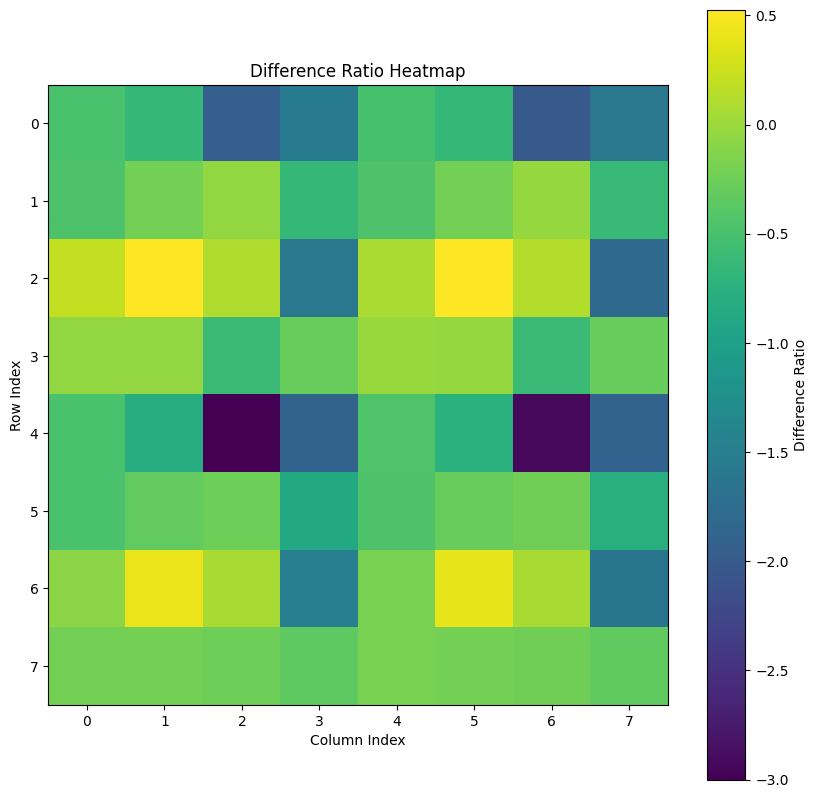

In [109]:
# plot a heatmap of the difference
plt.figure(figsize=(10, 10))
plt.imshow(diff_ratio, cmap='viridis')
plt.colorbar(label='Difference Ratio')
plt.title('Difference Ratio Heatmap')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

In [136]:
# report the eigenvalues of the matrix
(np.linalg.eigvals(out["OmegaX_out"]["tau_haipw_cov[M=truth,V=one_sided]"][0]),
np.linalg.eigvals(out["OmegaX_out"]["tau_haipw_cov[M=one_sided,V=one_sided]"][0]),
np.linalg.eigvals(out["OmegaX_out"]["tau_haipw_cov[M=regression,V=regression]"][0]))



(array([1.59821871e+05, 5.79893703e+03, 2.83151527e+03, 1.99614962e+03,
        3.23782817e+02, 8.08111429e+01, 6.20344659e+00, 3.15014173e+01]),
 array([1.56062622e+05, 5.72029339e+03, 2.84769208e+03, 2.13129258e+03,
        3.34988301e+02, 6.15695275e+00, 6.97310010e+01, 4.46393911e+01]),
 array([1.21358871e+06, 3.75982843e+03, 2.44904042e+03, 1.35128231e+03,
        1.39459758e+02, 5.34837639e+00, 5.18732531e+01, 3.56253825e+01]))

In [137]:
100/1e05

0.001

In [126]:
out["VecX_out"]["tau_haipw_cov[M=truth,V=one_sided]"][0] - out["VecX_out"]["tau_haipw_cov[M=regression,V=regression]"][0]

array([ -53432.47890793, -112122.97576268,  -23545.11681125,
        -42084.10437832,  -33874.28109055,  -71627.27154652,
        -14773.70501589,  -25589.85818616])